In [326]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [327]:
SOURCE_PATH = r'/datasets/final_provider/'

In [328]:
def get_files_names_from_folder():
    file_names_list = [SOURCE_PATH + name for name in os.listdir(SOURCE_PATH) if name.endswith('.csv')]
    return file_names_list

In [329]:
def merge_dfs():
    merged_df = pd.DataFrame()
    for file_name in get_files_names_from_folder():
        df = pd.read_csv(file_name)
        try:
            merged_df = pd.merge_ordered(df,merged_df, on = 'customerID')
        except KeyError:
            merged_df = df.copy()
    return merged_df

In [330]:
df = merge_dfs()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       6361 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


In [331]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

In [332]:
df.query('(EndDate != "No") and (Type != "Month-to-month") and (BeginDate >= "2018-01-01")')['BeginDate'].value_counts()

2018-03-01    4
2019-02-01    3
2018-10-01    2
2018-02-01    2
2018-11-01    2
2018-08-01    2
2018-01-01    2
2018-12-01    2
2018-05-01    1
2019-11-01    1
2019-09-01    1
2019-08-01    1
2018-07-01    1
2019-05-01    1
2019-07-01    1
2018-06-01    1
Name: BeginDate, dtype: int64

- Пропущенные значения в столбце TotalCharges обусловлены недавним началом действия договора (все в момент выгрузки данных)
- Несмотря на то, что все эти договора долгосрочные, в таблице есть данные с клиентами, которые расторгли подобный договор
- Пропущенные значения в этом столбце представлены в виде пробела

In [333]:
df = df.query('TotalCharges != " "')

- Для обработки пропущенных значений в столбце InternetService проверяем, подключена ли услуга "Интернет безопасность". Если да - заменяем "Unknown_type" (неизвестно какой тип подключения)
- Остальные пропуски заменяем на "No"

In [334]:
nan_int_services_query = df.loc[df['InternetService'].isna()]

for i in nan_int_services_query.index:
    if nan_int_services_query['OnlineSecurity'][i] == 'Yes':
        df.loc[i,'InternetService'] = 'Unknown_type'

In [335]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        680
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
dtype: int64

In [336]:
df = df.fillna('No')
df = df.reset_index(drop = True)
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [337]:
term_list = []
for i in range(len(df)):
    try:
        d1 = pd.to_datetime(df['BeginDate'][i], yearfirst = True)
        d2 = pd.to_datetime(df['EndDate'][i], yearfirst = True)
        term_list.append((d2 - d1).days)
    except:
        d1 = pd.to_datetime(df['BeginDate'][i], yearfirst = True)
        d2 = pd.to_datetime('2020-02-01', yearfirst = True)
        term_list.append((d2 - d1).days)

In [338]:
df.columns = [item.lower() for item in df.columns]
df['duration'] = term_list
df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,duration
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,Female,0,...,Yes,No,DSL,No,Yes,No,Yes,Yes,No,276
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,Male,0,...,No,Yes,DSL,No,No,No,No,No,Yes,276
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,...,No,No,Fiber optic,No,No,Yes,No,No,No,122
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Male,1,...,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,396
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.4,Female,1,...,No,No,Fiber optic,No,No,No,Yes,Yes,No,91


In [339]:
target = []
for item in df['enddate']:
    if item == 'No':
        target.append(1)
    else:
        target.append(0)

df['target'] = target
df['target'].value_counts()

1    5163
0    1869
Name: target, dtype: int64

- Наблюдается дисбаланс классов

In [340]:
encoder = OrdinalEncoder()
scaler = StandardScaler()

prep_df = pd.DataFrame(scaler.fit_transform(encoder.fit_transform(df)), columns = df.columns)

In [341]:
features = prep_df.drop(['customerid','enddate','begindate','target'], axis = 1)
target = df['target']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.3, random_state = 123)

print('train shape', features_train.shape)
print('test shape', features_test.shape)

train shape (4922, 18)
test shape (2110, 18)


#### Константная модель

In [342]:
target_const_ones = [1 for _ in range(int(len(target_test)/2))]
target_const_zeroes = [0 for _ in range(int(len(target_test)/2))]

target_const = target_const_ones + target_const_zeroes

#### RandomForest

In [343]:
model = RandomForestClassifier(random_state = 123)

parameters = {'n_estimators': [100,150,180,200],
              'max_depth': [20, 25, 30],
              'max_features': ['auto','sqrt','log2'],
              'criterion': ['gini','entropy'],
              'class_weight': ['balanced', 'balanced_subsample']
             }

CV = GridSearchCV(model, parameters, n_jobs = -1)
CV.fit(features_train, target_train)
CV.best_params_    

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 25,
 'max_features': 'auto',
 'n_estimators': 150}

In [354]:
model = RandomForestClassifier(max_depth = 25,
                               n_estimators = 150,
                               n_jobs = -1,
                               max_features = 'auto',
                               criterion = 'gini',
                               class_weight = 'balanced',
                               random_state = 123
                                )
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
predictions_train = model.predict(features_train)
probabilities_test = model.predict_proba(features_test)[:, 1]
probabilities_train = model.predict_proba(features_train)[:, 1]

In [355]:
print('RandomForest')
print('Accuracy',accuracy_score(target_test, predictions_test))
print('Auc',roc_auc_score(target_test, probabilities_test))

RandomForest
Accuracy 0.8075829383886256
Auc 0.8436945461439664


- Хотелось бы AUC повыше, поэтому попробую другую модель

#### CatBoost

In [356]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations = 1000,
                           learning_rate = 0.02,
                           l2_leaf_reg = 3,
                           boosting_type = 'Plain',
                           verbose = False)
model.fit(features_train, 
          target_train
         )

In [357]:
predictions_test = model.predict(features_test)
predictions_train = model.predict(features_train)
probabilities_test = model.predict_proba(features_test)[:, 1]
probabilities_train = model.predict_proba(features_train)[:, 1]

In [358]:
final_scores_df = pd.DataFrame(columns = ['TEST', 'TRAIN','CONST'])
final_scores_df['TEST'] = [accuracy_score(target_test, predictions_test), 
                           roc_auc_score(target_test, probabilities_test),
                           recall_score(target_test, predictions_test),
                           precision_score(target_test, predictions_test),
                           f1_score(target_test, predictions_test)
                          ]
final_scores_df['TRAIN'] = [accuracy_score(target_train, predictions_train),
                            roc_auc_score(target_train, probabilities_train),
                            recall_score(target_train, predictions_train),
                            precision_score(target_train, predictions_train),
                            f1_score(target_train, predictions_train)
                           ]
final_scores_df['CONST'] = [accuracy_score(target_const, predictions_test), 
                           roc_auc_score(target_const, probabilities_test),
                           recall_score(target_const, predictions_test),
                           precision_score(target_const, predictions_test),
                           f1_score(target_const, predictions_test)
                          ]
final_scores_df.index = ['ACCURACY','AUC','RECALL','PRECISION','F1']

In [359]:
final_scores_df

,TEST,TRAIN,CONST
ACCURACY,0.847867,0.914059,0.506635
AUC,0.893833,0.965030,0.509766
RECALL,0.942692,0.973407,0.810427
PRECISION,0.863208,0.914866,0.504127
F1,0.901200,0.943229,0.621592


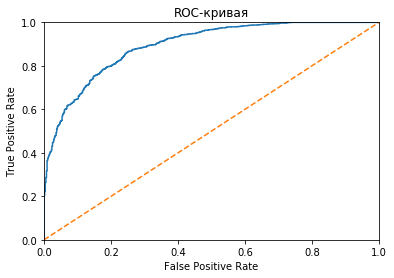

In [360]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()